In [2]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
sns.set_palette("RdGy")

import pandas as pd

%load_ext autoreload
%autoreload 2

## Snowload
---
Load data and interpolate the design value field

Text(0.5, 1.0, 'KDE Distribution of snw Values')

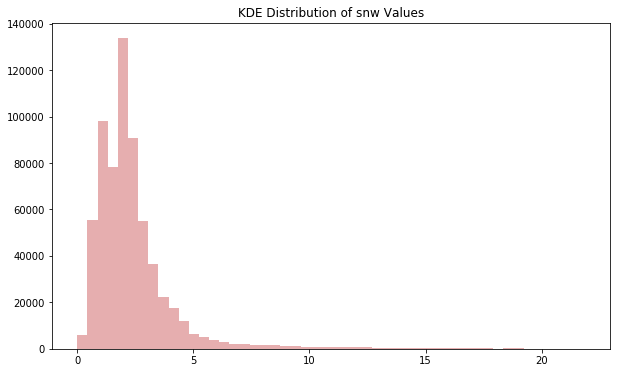

In [20]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/storage/home/nannau/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
# midx = interp_dict['idx']

north_master_idx = interp_dict['irlat_ens'] > -7.

midx = np.logical_and(north_master_idx, master_idx)

iens = (interp_dict['iens'][:, midx]).T
#oldiens = iens.copy()

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler(with_mean=True, with_std=True)
#iens = scaler.fit_transform(iens)

plt.figure(figsize=(10, 6))
# sns.distplot(oldiens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='non-anomaly')
sns.distplot(iens[..., 0], kde = False, kde_kws = {'shade': True,'linewidth': 3}, label='anomaly')
plt.title('KDE Distribution of {} Values'.format(dv))

Plot distribution.

Perform singular value decomposition

In [21]:
print(iens.shape)
u, s, vT = np.linalg.svd(iens.T, full_matrices=False)
# uold, sold, vTold = np.linalg.svd(oldiens.T, full_matrices=False)

#del u
# del uold
vT.shape

(644782, 35)


(35, 644782)

Load the quantile station data

In [22]:
df = pd.read_csv('/home/nannau/Downloads/Interim_snow_load_LRstations_delivered.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,1.954635
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.729036
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.352290
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.752725
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.420390


In [23]:
dv = 'SL50 (kPa)'

In [24]:
ndf = match_coords(df, interp_dict, dv, midx)
print("There are ", ndf.shape, "real station observations to fit.")

There are  (477, 5) real station observations to fit.


#### Create the pseudo observations and regress

In [25]:
obs_idx = generate_pseudo_obs(iens.T, 0.0003)
print("Taking", obs_idx[0].shape, "pseudo observations")

Taking (193,) pseudo observations


In [26]:
print(vT.shape)
# vT = vT.T
obs = iens.T[obs_idx]
eofs = vT[:, obs_idx[1]]
# eofsold = vTold[:, obs_idx[1]]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

(35, 644782)
Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (35, 193) 
Matched Obs shape:  (193,)


Fit the EOFs tot he pseudo observations and predict their values

In [27]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

slope 0.9958035332191574 r2_val 0.9978995606869245


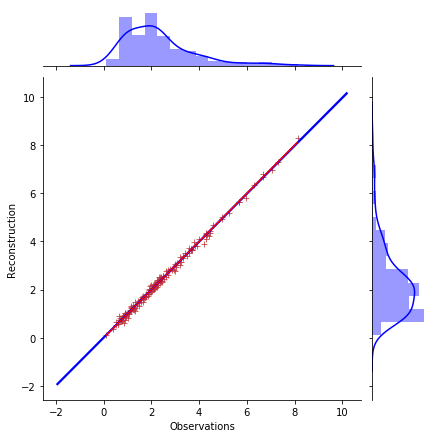

In [28]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [29]:
robs_idx = ndf['matched_idx']
robs = ((ndf[dv].values))# - ndf[dv].mean(axis=0))#/ndf[dv].std(axis=0)
vT.shape, robs_idx.shape
reofs = vT[:, robs_idx].T
reofs.shape, robs.shape, #obs.shape

((477, 35), (477,))

Compare the distributions of the station observations and of the models

Fit the model and predict it

In [30]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()
linrpredictions.shape

(477,)

slope 0.31092977509998765 r2_val 0.5576107738377977
Std deviation ratio of vectors [models/]: 0.050209490415708526


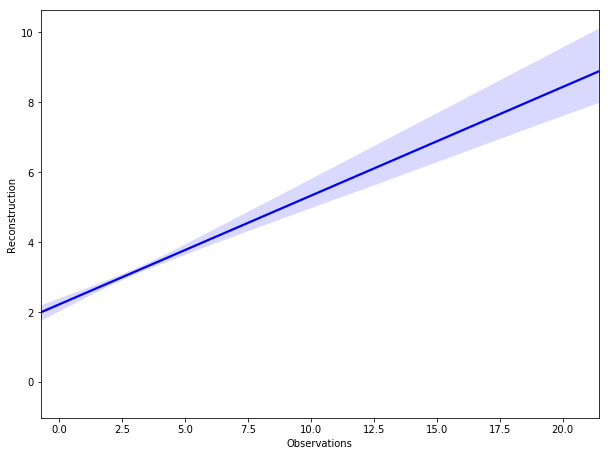

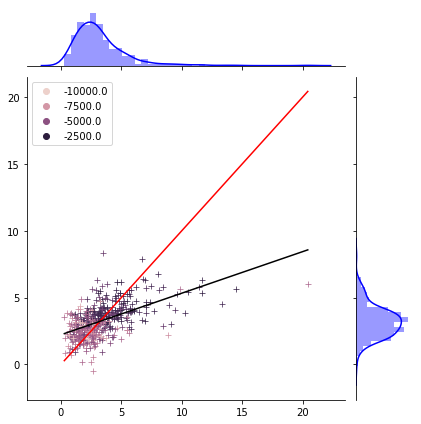

In [31]:
fig, ax = plt.subplots(figsize=(10, 7.5))
sns.jointplot(robs, linrpredictions, ax=ax,  kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions,
                marker='+',
                hue=ndf['lon']*ndf['lat'],
                )

sns.lineplot(
            robs.T, 
            robs.T,
            color='r',
            dashes=True
)


ax.set_xlabel('Observations')
ax.set_ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)

sns.lineplot(robs.T,
            robs.T*slope + intercept,
            color='black',
            dashes=True
)

print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

In [32]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[midx] = rmodel.predict(vT.T)
dv_recon[~midx] = np.nan 

In [33]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

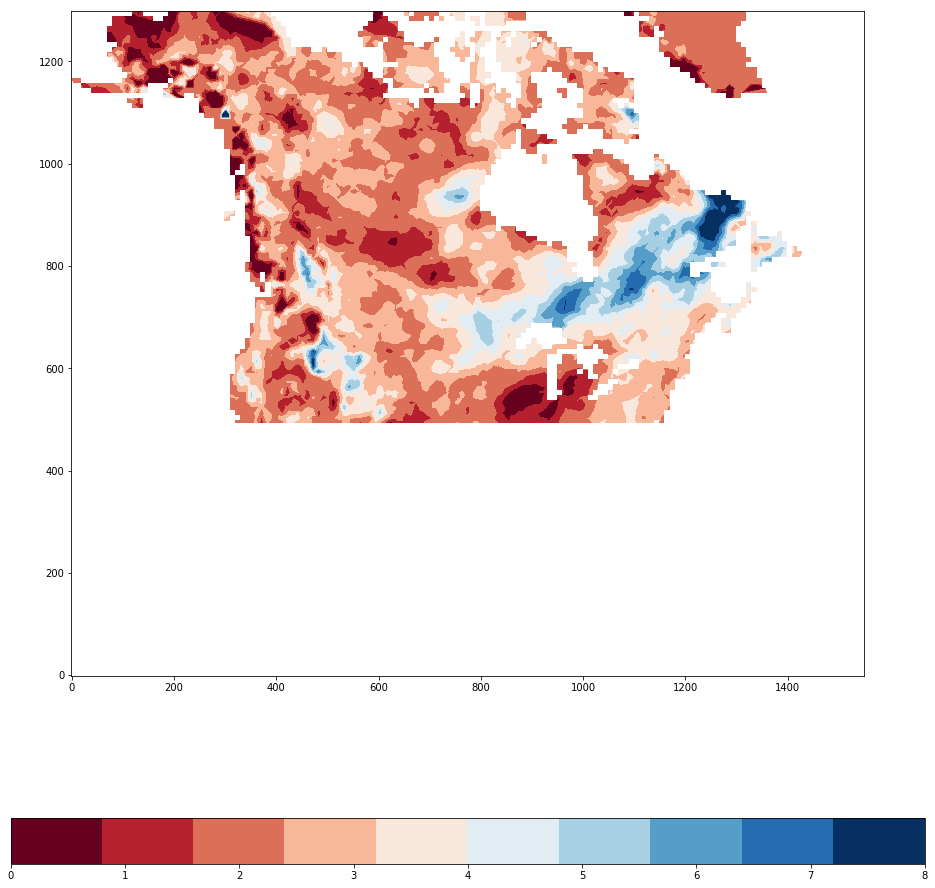

In [34]:
plt.figure(figsize=(15, 15))
vmin, vmax = 0, 8
plt.imshow(dv_recon_sq, cmap=plt.cm.get_cmap('RdBu', 10), vmin=vmin, vmax=vmax, origin='lower')
plt.tight_layout(pad=6.5)
plt.colorbar(orientation='horizontal')

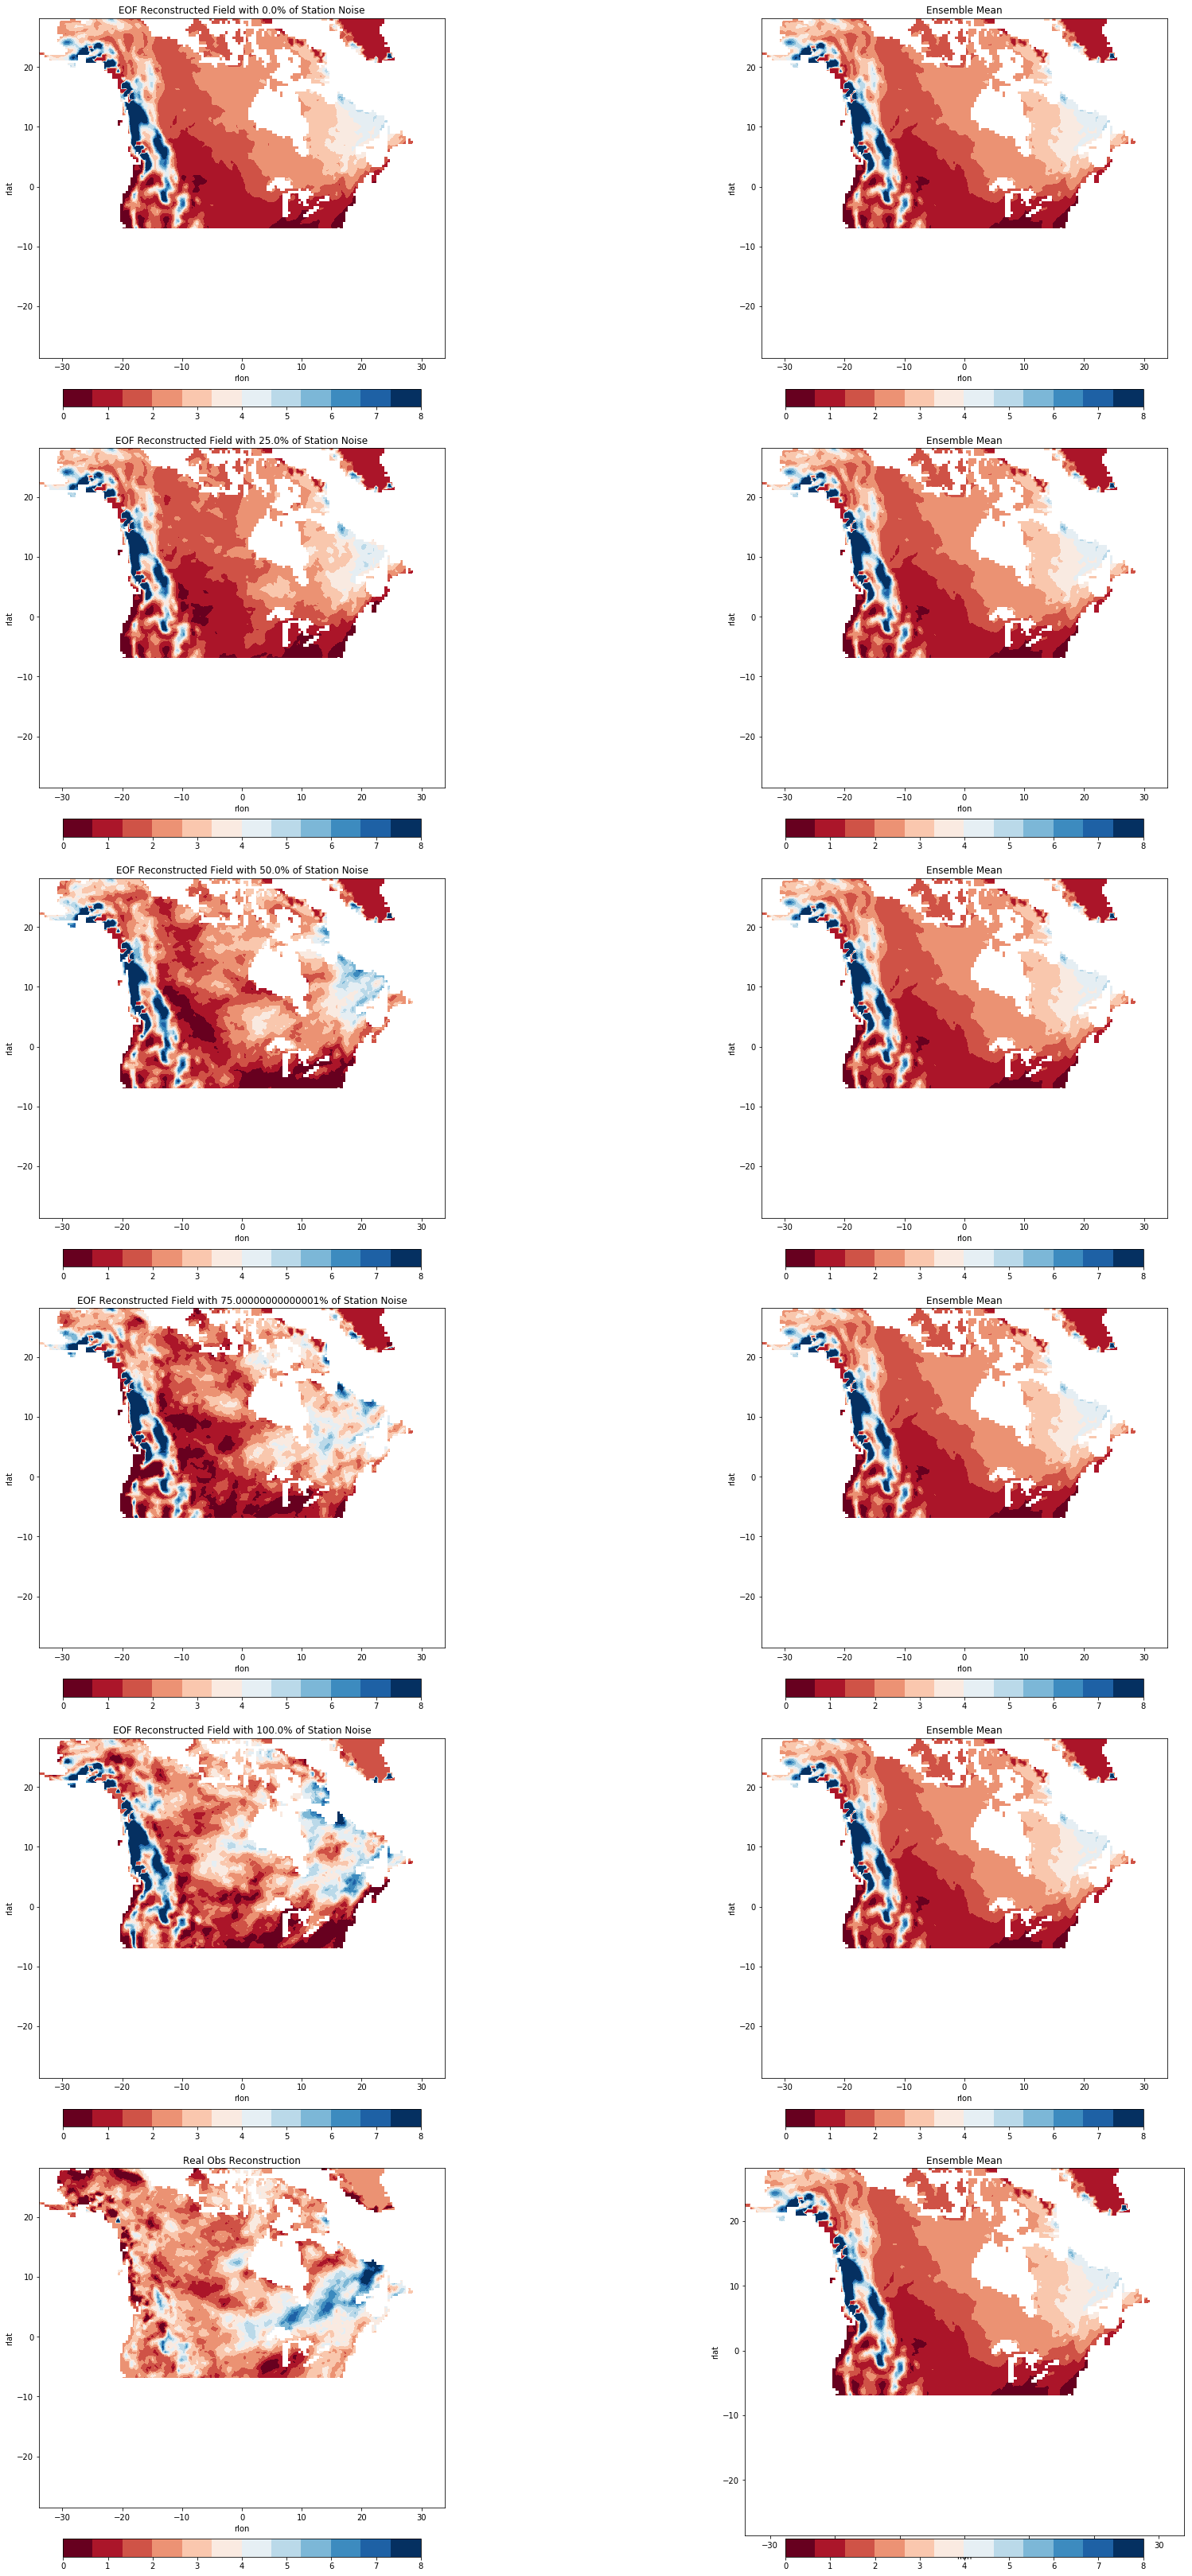

In [35]:
# del iens_copy, X, predictions, y, X_v
iens_copy = np.full_like(np.zeros(interp_dict['iens'].shape), np.nan)
X_v = interp_dict['iens']
X_v[:, ~midx] = np.nan 
    
N=5
fig, ax = plt.subplots(N+1, 2, figsize=(30,45))
for i, sd in enumerate(np.linspace(0, np.std(robs), N)):
    y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
    model = fit_eof(eofs.T, y)

    predictions = predict_dv(model, vT.T)
    iens_copy[:, midx] = predictions
    
    X = np.reshape(iens_copy, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    X_v = np.reshape(X_v, (iens_copy.shape[0], interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0]))
    vmin, vmax = 0, 8
    xc, yc = interp_dict['irlon'], interp_dict['irlat']
    
    ax[i, 0].set_title('EOF Reconstructed Field with {}% of Station Noise'.format(100*sd/np.std(robs)))
    ax[i, 0].set_xlabel('rlon')
    ax[i, 0].set_ylabel('rlat')
    img = ax[i, 0].imshow(X[0, ...], origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[xc.min(), xc.max(), yc.min(), yc.max()])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 0], fraction=0.046, pad=0.08)

#     sns.distplot(robs, ax=ax[i, 1], color='b', label='Real')
#     sns.distplot(y, ax=ax[i, 1], color='r', label='Pred')
#     ax[i, 1].set_xlabel('Snowload')
#     ax[i, 1].legend()

    ax[i, 1].set_title('Ensemble Mean')
    ax[i, 1].set_xlabel('rlon')
    ax[i, 1].set_ylabel('rlat')
    img = ax[i, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[xc.min(), xc.max(), yc.min(), yc.max()])
    plt.colorbar(img, orientation='horizontal', ax=ax[i, 1], fraction=0.046, pad=0.08)
    
    
ax[5, 0].set_title('Real Obs Reconstruction')
ax[5, 0].set_xlabel('rlon')
ax[5, 0].set_ylabel('rlat')    
img = ax[5, 0].imshow(dv_recon_sq, cmap=plt.cm.get_cmap('RdBu', 12), vmin=vmin, vmax=vmax, origin='lower', extent=[xc.min(), xc.max(), yc.min(), yc.max()])
plt.colorbar(img, orientation='horizontal', ax=ax[5, 0], fraction=0.046, pad=0.08)

ax[5, 1].set_title('Ensemble Mean')
ax[5, 1].set_xlabel('rlon')
ax[5, 1].set_ylabel('rlat')
img = ax[5, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[xc.min(), xc.max(), yc.min(), yc.max()])
plt.colorbar(img, orientation='horizontal', ax=ax[5, 1], fraction=0.046, pad=0.008)
# ax[6, 1].set_title('Ensemble Mean')
# ax[6, 1].set_xlabel('rlon')
# ax[6, 1].set_ylabel('rlat')
# img = ax[6, 1].imshow(X_v.mean(axis=0), origin='lower', cmap=plt.cm.get_cmap('RdBu', 12), label='EOF', vmin=vmin, vmax=vmax, extent=[xc.min(), xc.max(), yc.min(), yc.max()])
# plt.colorbar(img, orientation='horizontal', ax=ax[6, 1], fraction=0.046, pad=0.08)

plt.tight_layout(pad=0.8, h_pad=1.9, w_pad=0.1)
plt.savefig('recon_mean_comparison_spatial.pdf')
del iens_copy, X, predictions, y, X_v